In [ ]:
%pip install requests
%pip install beautifulsoup4

In [ ]:
import re
import requests

In [ ]:

from bs4 import BeautifulSoup


def get_price_for_product_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    scripts = soup.find_all('script')
    for script in scripts:
        if 'EM.product_id' in script.text:
            product_id_search = re.search(r'EM.productDiscountedPrice\s=\s([0-9.]+);', script.text)
            if product_id_search:
                return float(product_id_search.group(1))
    return None


def get_reviews_for_product_by_url(product_url):
    # remove potential '?' at the end of the url
    if product_url.endswith('?'):
        product_url = product_url[:-1]

    # remove potential '#used-products' at the end of the url
    if product_url.endswith('#used-products'):
        product_url = product_url[:-len('#used-products')]

    # check for potentially missing slash at the very end
    if not product_url.endswith('/'):
        product_url += '/'

    # --------------------- endpoint URL ---------------------

    substr_to_remove = 'https://www.emag.ro/'
    endpoint_url = 'https://www.emag.ro/product-feedback/'
    endpoint_url += product_url.replace(substr_to_remove, '')
    endpoint_url += 'reviews/list'

    # --------------------- GET request ---------------------

    product_response = requests.get(product_url)
    product_html = product_response.text
    product_soup = BeautifulSoup(product_html, 'html.parser')

    # --------------------- number of reviews ---------------------

    # get the number of reviews. e.g. for 256 we iterate 26 times, for 5 we iterate 1 time
    # res = product_soup.find_all('p', class_='small semibold font-size-sm text-muted')
    # reviews_number = re.search(r'\d+', str(res[0])).group()

    # ^^^^^ this approach got dumped because it was only working for products 
    #       that actually had any number of reviews

    offset = 0

    params = {
        "source_id": 7,
        "page[limit]": 10,
        "page[offset]": offset,
        "sort[created]": "desc"
    }

    response = requests.get(endpoint_url, params=params)
    data = response.json()
    # print(data)
    reviews_number = data['reviews']['count']
    reviews_number = int(reviews_number)

    if reviews_number <= 0:
        return []

    # --------------------- product title ---------------------

    product_title = product_soup.find('h1', class_='page-title').get_text()
    # get rid of multiple whitespaces and \n
    product_title = re.sub(r'\s+', ' ', product_title).strip()

    # --------------------- product price ---------------------

    # product_price = product_soup.find('p', class_='product-new-price').get_text()
    # # get rid of ' Lei'
    # product_price = product_price[:-4] 
    # # transform string '1.920,00' to float '1920.0'
    # product_price = float(product_price.replace('.', '').replace(',', '.')) 

    # ^^^^^ this approach got dumped

    # used this approach instead of looking through the HTML tags (like above)
    # because formats were too many, e.g. 'de la xxx.xx Lei' when multiple offers exist

    scripts = product_soup.find_all('script')
    for script in scripts:
        if 'EM.product_id' in script.text:
            product_id_search = re.search(r'EM.productDiscountedPrice\s=\s([0-9.]+);', script.text)
            if product_id_search:
                product_price = float(product_id_search.group(1))
                break

    # --------------------- get reviews ---------------------

    review_titles_arr = []
    review_ratings_arr = []
    review_contents_arr = []
    review_verified_users_arr = []

    while offset < reviews_number and offset < 50:
        params = {
            "source_id": 7,
            "page[limit]": 10,
            "page[offset]": offset,
            "sort[created]": "desc"
        }

        response = requests.get(endpoint_url, params=params)
        data = response.json()

        items = data['reviews']['items']

        review_titles = [item['title'] for item in items]
        review_ratings = [item['rating'] for item in items]
        review_contents = [item['content'] for item in items]
        review_verified_users = [item['is_bought'] for item in items]

        review_titles_arr += review_titles
        review_ratings_arr += review_ratings
        review_contents_arr += review_contents
        review_verified_users_arr += review_verified_users

        offset += 10

    # --------------------- final product array ---------------------

    merged_list = [
        {
            'product_title': product_title,
            'product_price': product_price,
            'review_title': review_title, 
            'review_rating': review_rating, 
            'review_verified_buyer': review_verified_buyer, 
            'review_content': review_content
        }
        for review_title, review_content, review_rating, review_verified_buyer in zip(review_titles_arr, review_contents_arr, review_ratings_arr, review_verified_users_arr)
    ]

    return merged_list

In [ ]:
# --------------------- get current listings' indices ---------------------

def get_current_page_listings_indices(url):
    page_response = requests.get(url)
    page_html = page_response.text
    page_soup = BeautifulSoup(page_html, 'html.parser')

    try:
        listings = page_soup.find('div', class_='control-label small hidden-xs hidden-sm js-listing-pagination').get_text()
    except AttributeError:
        return [-1, -1]

    if listings is not None:
        # Define the pattern to match the numbers, like:
        # '1 - 5 din 5 produse'
        # '1 - 60 din 262 de produse'
        pattern = r'(\d+)\D+(\d+)\D+(\d+)'

        # Extract the numbers from input1
        match1 = re.search(pattern, listings)
        k1 = int(match1.group(1))
        k2 = int(match1.group(2))

        k3 = int (match1.group(3))

        return [k1, k2]
    

# --------------------- get the total number of listings for the current search ---------------------    

def get_total_number_of_listings(url):
    page_response = requests.get(url)
    page_html = page_response.text
    page_soup = BeautifulSoup(page_html, 'html.parser')

    try:
        listings = page_soup.find('div', class_='control-label small hidden-xs hidden-sm js-listing-pagination').get_text()
    except AttributeError:
        return -1

    if listings is not None:
        # Define the pattern to match the numbers, like:
        # '1 - 5 din 5 produse'
        # '1 - 60 din 262 de produse'
        pattern = r'(\d+)\D+(\d+)\D+(\d+)'

        # Extract the numbers from input1
        match1 = re.search(pattern, listings)
        k = int(match1.group(3))

        return k

In [ ]:
# --------------------- get current listings' URLs ---------------------

def get_current_page_product_links(url):
    response = requests.get(url)
    html_content = response.text

    soup = BeautifulSoup(html_content, 'html.parser')

    product_links = soup.find_all('a', class_='card-v2-title semibold mrg-btm-xxs js-product-url')    

    return product_links

In [ ]:
import math

# --------------------- main function for getting all reviews for all search results ---------------------

def get_total_reviews(url):
    total_reviews = []
    total_products = get_total_number_of_listings(url)
    print(f"total products: {total_products}")

    if total_products > 0:
        rounds = math.ceil(float(total_products / 60))
        print(f"rounds: {rounds}")

        k = 0
        page_number = 1
        final_url = url

        [from_product, to_product] = get_current_page_listings_indices(url)

        for i in range(rounds):
            print(f"from: {from_product}, to: {to_product}, total: {total_products}")
            product_links = get_current_page_product_links(final_url)

            # aici e ultima pagina
            if i == rounds - 1:
                # facem de total % 60 ori
                limit = total_products % 60
            else:
                # facem de 60 de ori
                limit = 60

            for j, item in enumerate(product_links):
                if j >= limit:
                    break
                else:
                    print(f"getting reviews for {item['href']}")
                    total_reviews += get_reviews_for_product_by_url(item['href'])

            page_number += 1
            
            final_url = f'{url}p{page_number}'
            [from_product, to_product] = get_current_page_listings_indices(final_url)
        
    return total_reviews

In [ ]:
# url = 'https://www.emag.ro/search/monitor dell/' # 140 rez
# url = 'https://www.emag.ro/search/monitor benq/' # 81 rez
# url = 'https://www.emag.ro/search/sony%20wh-1000xm5/' # 3 rez
# url = 'https://www.emag.ro/search/hrana-pentru-pisici/pret,intre-105-si-191/Hrana+uscata+pentru+pisici+Acana+Wild+Prairie+NEW%2C+4.5+kg/'
url = 'https://www.emag.ro/search/iphone 14 pro max/' # 108 rez
# url = 'https://www.emag.ro/search/macbook pro stand lemn maro negru/'
    # MUST HAVE / AT END!!!!!

reviews = get_total_reviews(url)

if reviews is not None:
    for review in reviews:
        print(review)

In [ ]:
# --------------------- write all reviews to a CSV file ---------------------

import csv
def write_reviews_to_csv(reviews_param, file_name):
    file_csv = file_name

    header = reviews_param[0].keys()

    with open(file_csv, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=header)
        writer.writeheader()
        writer.writerows(reviews_param)

    print(f"Data has been written to {file_csv}")

In [ ]:
write_reviews_to_csv(reviews, 'reviews_output.csv')

In [ ]:
import pandas as pd

# Path to the CSV file
csv_file = 'reviews_output.csv'

# Define the column names and their respective data types
column_names = ['product_title', 'product_price', 'review_title', 'review_rating', 'review_verified_buyer', 'review_content']
column_types = {'product_title': str, 'product_price': float, 'review_title': str, 'review_rating': int, 'review_verified_buyer': bool, 'review_content': str}

# Read the CSV file into a DataFrame
reviews_df = pd.read_csv(csv_file, names=column_names, dtype=column_types, header=0)

In [ ]:
%pip install pandas
%pip install demoji
%pip install nltk

In [ ]:
%pip install uuid
%pip install json

In [124]:
import requests, uuid, json

with open('connectivity_secrets.json') as file:
    data = json.load(file)
azure_translator_key = data['azure_translator_key']

def translate_text(text):
    # Add your key and endpoint
    key = azure_translator_key
    endpoint = "https://api.cognitive.microsofttranslator.com"

    # location, also known as region.
    # required if you're using a multi-service or regional (not global) resource. It can be found in the Azure portal on the Keys and Endpoint page.
    location = "francecentral"

    path = '/translate'
    constructed_url = endpoint + path

    params = {
        'api-version': '3.0',
        'from': 'ro',
        'to': ['en']
    }

    headers = {
        'Ocp-Apim-Subscription-Key': key,
        # location required if you're using a multi-service or regional (not global) resource.
        'Ocp-Apim-Subscription-Region': location,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    # You can pass more than one object in body.
    body = [{
        'text': text
    }]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()

    # print(json.dumps(response, sort_keys=True, ensure_ascii=False, indent=4, separators=(',', ': ')))

    return response[0]['translations'][0]['text']

In [ ]:
# drop reviews that exceed 2500 chars as they would be too resource consuming for our character-limited translation API
reviews_df = reviews_df[reviews_df['review_content'].str.len() <= 2500]

# drop where we find NaN for title or content
reviews_df = reviews_df.dropna(subset=['review_title', 'review_content'])

# drop duplicate reviews (e.g., A 'deep purple' iPhone will have the exact same reviews as a 'emerald green' one)
reviews_df.drop_duplicates(subset=['product_title', 'product_price', 'review_title', 'review_rating', 'review_verified_buyer', 'review_content'], inplace=True)

In [ ]:
# translate the 'title' and 'content' columns from RO -> EN
reviews_df['review_title_en'] = reviews_df['review_title'].apply(translate_text)
reviews_df['review_content_en'] = reviews_df['review_content'].apply(translate_text)

In [ ]:
reviews_df.to_csv('reviews_translated_output.csv', index=False)

In [ ]:
reviews_df = reviews_df.drop(['review_title', 'review_content'], axis=1)

In [ ]:
reviews_df = reviews_df.copy()

In [ ]:
%pip install scikit-learn

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import nltk
nltk.download('wordnet')

In [111]:
# --------------------- 2. Second Topic: Data Cleaning & Preprocessing ---------------------

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def preprocess(text):
    # remove html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenize words
    words = word_tokenize(text)

    # Remove stopwords and lemmatize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    return ' '.join(words)

In [112]:
reviews_df['review_content_en'] = reviews_df['review_content_en'].astype(str)
reviews_df['review_title_en'] = reviews_df['review_title_en'].astype(str)

# count how many words we have BEFORE preprocessing the data
reviews_df['word_count_before'] = reviews_df['review_content_en'].str.split().apply(len) + reviews_df['review_title_en'].str.split().apply(len)

# remove special characters and digits from 'review_title_en' and 'review_content_en'
reviews_df['review_title_en'] = reviews_df['review_title_en'].str.replace("[^a-zA-Z#]", " ")
reviews_df['review_content_en'] = reviews_df['review_content_en'].str.replace("[^a-zA-Z#]", " ")

reviews_df['review_content_en'] = reviews_df['review_content_en'].apply(preprocess)

# count how many words we have AFTER preprocessing the data
reviews_df['word_count_after'] = reviews_df['review_content_en'].str.split().apply(len) + reviews_df['review_title_en'].str.split().apply(len)

/var/folders/_w/kl4xvqnd6_q9v746200yzqjw0000gn/T/ipykernel_1483/390091245.py:8: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/_w/kl4xvqnd6_q9v746200yzqjw0000gn/T/ipykernel_1483/390091245.py:9: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
%pip install plotly

In [114]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace_before = go.Scatter(
    x=reviews_df.index,
    y=reviews_df['word_count_before'],
    mode='lines',
    name='Words Before Preprocessing'
)

trace_removed = go.Scatter(
    x=reviews_df.index,
    y=reviews_df['word_count_before'] - reviews_df['word_count_after'],
    mode='lines',
    name='Words Removed During Preprocessing'
)

layout = go.Layout(
    title='Number of Words Before and After Preprocessing',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Number of Words'),
    showlegend=True,
)

fig = go.Figure(data=[trace_before, trace_removed], layout=layout)
fig.show()



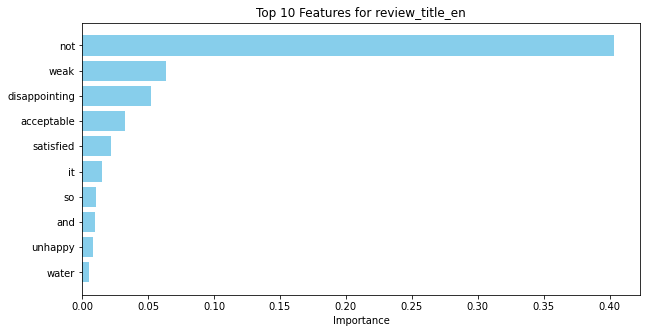

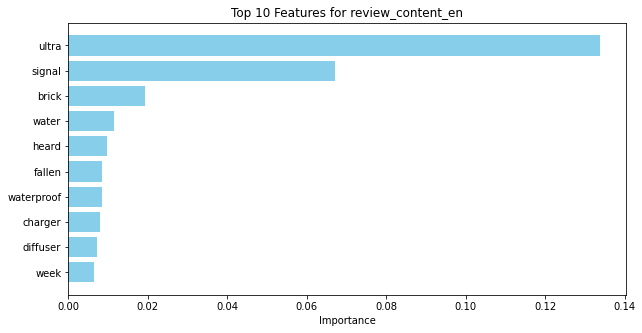

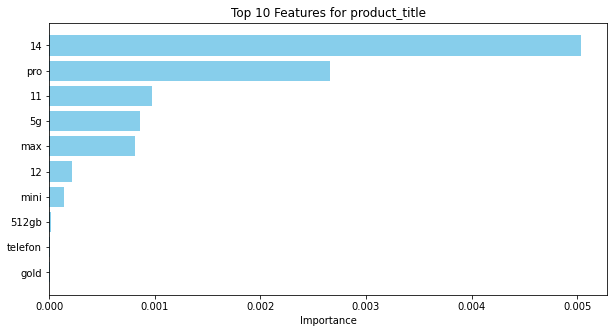

In [115]:
# --------------------- 3 and 4. Third and Fourth Topics: TF-IDF, Feature Importance Analysis ---------------------

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import numpy as np
import matplotlib.pyplot as plt

df = reviews_df.copy()

df['review_verified_buyer'] = df['review_verified_buyer'].astype(int)

vectorizer1 = TfidfVectorizer()
vectorizer2 = TfidfVectorizer()
vectorizer3 = TfidfVectorizer()

# fit and transform 'review_title_en', 'review_content_en' and 'product_title' columns
tfidf_review_title = vectorizer1.fit_transform(df['review_title_en'])
tfidf_review_content = vectorizer2.fit_transform(df['review_content_en'])
tfidf_product_title = vectorizer3.fit_transform(df['product_title'])

# stack all numeric and tf-idf features together
X = hstack([df[['product_price', 'review_verified_buyer']], tfidf_review_title, tfidf_review_content, tfidf_product_title])

# target
y = df['review_rating']

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

# feature importances
importances = model.feature_importances_

def plot_top_features(vectorizer, importances, top_n, plot_title):
    feature_names = vectorizer.get_feature_names_out()

    tfidf_importances = importances[:len(feature_names)]

    features_importances = list(zip(feature_names, tfidf_importances))

    sorted_features_importances = sorted(features_importances, key=lambda x: x[1], reverse=True)

    # top n features
    top_features = sorted_features_importances[:top_n]

    words, importances = zip(*top_features)

    plt.figure(figsize=(10, 5))
    plt.barh(words, importances, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top {} Features for {}'.format(top_n, plot_title))
    plt.gca().invert_yaxis()  # Invert y axis to show the top feature at the top
    plt.show()

top_n = 10

start1 = 2
end1 = 2 + tfidf_review_title.shape[1]
start2 = end1
end2 = start2 + tfidf_review_content.shape[1]
start3 = end2
end3 = start3 + tfidf_product_title.shape[1]

plot_top_features(vectorizer1, importances[start1:end1], top_n, 'review_title_en')
plot_top_features(vectorizer2, importances[start2:end2], top_n, 'review_content_en')
plot_top_features(vectorizer3, importances[start3:end3], top_n, 'product_title')

In [ ]:
%pip install gensim

In [116]:
# --------------------- 5. Fifth Topic: Topic Modelling ---------------------

import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
    text = text.lower()
    tokenized_text = word_tokenize(text)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in remove_stopwords]
    return lemmatized_words

reviews = reviews_df['review_content_en'].apply(preprocess)

dictionary = corpora.Dictionary(reviews)

corpus = [dictionary.doc2bow(review) for review in reviews]

# train the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = ldamodel.show_topics()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/roberthevesi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/roberthevesi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%pip install pyLDAvis

In [119]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(ldamodel, corpus, dictionary, n_jobs=1)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.095737 -0.065152       1        1  26.902197
4      0.005471 -0.016765       2        1  20.390430
0     -0.090988 -0.173407       3        1  19.102962
3     -0.186826  0.150071       4        1  18.135949
2      0.176605  0.105253       5        1  15.468462, topic_info=          Term         Freq        Total Category  logprob  loglift
10          br  3108.000000  3108.000000  Default  30.0000  30.0000
61     pleased   826.000000   826.000000  Default  29.0000  29.0000
28   recommend   728.000000   728.000000  Default  28.0000  28.0000
77         max   433.000000   433.000000  Default  27.0000  27.0000
79         pro   822.000000   822.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
469       much    81.959516   389.594847   Topic5  -4.9395   0.3075
29      screen    81.899352   416.630922   Topic5  -4.9402   0.2397
53        last    75.334662   292.481194   Topic5  -5.0238   0.5099
14         day    80.402396   724.383379   Topic5  -4.9587  -0.3319
44     quality    73.664594   612.403512   Topic5  -5.0462  -0.2515

[357 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1096      1  0.964897   absurd
990       2  0.994777   access
689       4  0.967143  adapter
582       3  0.988443    admit
583       2  0.286090      ago
...     ...       ...      ...
94        2  0.085106     year
94        3  0.452608     year
94        4  0.282396     year
169       1  0.975737  youtube
1117      1  0.973615     zoom

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

In [120]:
# --------------------- 6. Sixth Topic: Sentiment Analysis ---------------------

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

reviews_df['sentiment_score'] = reviews_df['review_content_en'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

reviews_df['sentiment_label'] = reviews_df['sentiment_score'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

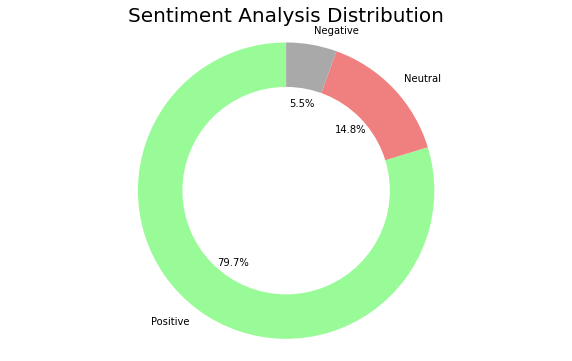

In [121]:
import matplotlib.pyplot as plt

sentiments = reviews_df['sentiment_label'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(sentiments, labels=sentiments.index, startangle=90, autopct='%1.1f%%',
        colors=['#98FB98', '#F08080', '#A9A9A9'])  # lightgreen, lightcoral, darkgray

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  

plt.title('Sentiment Analysis Distribution', size=20)
plt.show()